# Predicting phase transition of the two-dimensional Ising model

In this notebook we will be doing a binary classification of the two-dimensional Ising model where we try to predict if a given state is `ordered` or `disordered`.

## The Ising model

The Hamiltonian of the two-dimensional Ising model without an external field for a constant coupling constant $J$ is given by

\begin{align}
    H = -J \sum_{\langle ij\rangle} S_i S_j,
\end{align}

where $S_i \in \{-1, 1\}$ and $\langle ij \rangle$ signifies that we only iterate over the nearest neighbors in the lattice. We will be looking at a system of $L = 40$ spins in each dimension, i.e., $L^2 = 1600$ spins in total. Opposed to the one-dimensional Ising model we will get a phase transition from an _ordered_ phase to a _disordered_ phase at the critical temperature

\begin{align}
    \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{2}\right)} \approx 2.26,
\end{align}

as shown by Lars Onsager.

### The goal

We wish in this notebook to use _logistic regression_ to predict when a phase transition occurs. The data we will look at is a set of spin configurations, i.e., individual lattices with spins, labeled _ordered_ `1` or _disordered_ `0`. Our job is to build a model which will take in a spin configuration and predict whether or not the spin configuration constitutes an ordered or a disordered phase. To achieve this we will represent the lattices as flattened arrays with $1600$ elements instead of a matrix of $40 \times 40$ elements. As an extra test of the performance of the algorithms we will divide the dataset into three pieces. We will do a conventional train-test-split on a combination of totally ordered and totally disordered phases. The remaining "critical-like" states will be used as test data which we hope the model will be able to make good extrapolated predictions on.

In [1]:
import pickle
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as skms
import sklearn.linear_model as skl
import sklearn.metrics as skm
import tqdm
import copy
import time
from IPython.display import display

%matplotlib inline

sns.set(color_codes=True)

In [2]:
%%javascript
// Fill entire cell with output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Reading in the data

Using the data from [here](https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/) (specifically the two datasets named `Ising2DFM_reSample_L40_T=All.pkl` and `Ising2DFM_reSample_L40_T=All_labels.pkl`) we have to unpack the data into numpy arrays.

In [3]:
filenames = glob.glob(os.path.join("..", "dat", "*"))
label_filename = list(filter(lambda x: "label" in x, filenames))[0]
dat_filename = list(filter(lambda x: "label" not in x, filenames))[0]

# Read in the labels
with open(label_filename, "rb") as f:
    labels = pickle.load(f)

# Read in the corresponding configurations
with open(dat_filename, "rb") as f:
    data = np.unpackbits(pickle.load(f)).reshape(-1, 1600).astype("int")

# Set spin-down to -1
data[data == 0] = -1

This dataset consists of $10000$ samples, i.e., $10000$ spin configurations with $40 \times 40$ spins each, for $16$ temperatures between $0.25$ to $4.0$. Next we create a train/test-split and keep the data in the critical phase as a separate dataset for extrapolation-testing.

In [4]:
# Set up slices of the dataset
ordered = slice(0, 70000)
critical = slice(70000, 100000)
disordered = slice(100000, 160000)

X_train, X_test, y_train, y_test = skms.train_test_split(
    np.concatenate((data[ordered], data[disordered])),
    np.concatenate((labels[ordered], labels[disordered])),
    test_size=0.95
)

__Note:__ Using a small training set yields a better accuracy. This will be discussed in the end.

## Logistic regression

Logistic regression is a linear model for classification. Recalling the cost function for ordinary least squares with both L2 (ridge) and L1 (LASSO) penalties we will see that the logistic cost function is very similar. In OLS we wish to predict a continuous variable $\hat{y}$ using

\begin{align}
    \hat{y} = X\omega,
\end{align}

where $X \in \mathbb{R}^{n \times p}$ is the input data and $\omega^{p \times d}$ are the weights of the regression. In a classification setting (binary classification in our situation) we are interested in a positive or negative answer. We can thus define either answer to be above or below some threshold. But, in order to limit the size of the answer and also to get a probability interpretation on how sure we are for either answer we can compute the sigmoid function of OLS. That is,

\begin{align}
    f(X\omega) = \frac{1}{1 + \exp(-X\omega)}.
\end{align}

We are thus interested in minimizing the following cost function

\begin{align}
    C(X, \omega) = \sum_{i = 1}^n \left\{
        - y_i\log\left( f(x_i^T\omega) \right)
        - (1 - y_i)\log\left[1 - f(x_i^T\omega)\right]
    \right\},
\end{align}

where we will restrict ourselves to a value for $f(z)$ as the sigmoid described above. We can also tack on a L2 (Ridge) or L1 (LASSO) penalization to this cost function in the same manner we did for linear regression.

### Exploring the logistic regression

The penalization factor $\lambda$ is inverted in the case of the logistic regression model we use. We will explore several values of $\lambda$ using both L1 and L2 penalization. We do this using a grid search over different parameters and run a 3-fold cross validation for each configuration. In other words, we fit a model 3 times for each configuration of the hyper parameters.

In [5]:
lambdas = np.logspace(-7, -1, 7)

param_grid = {
    "C": list(1.0/lambdas),
    "penalty": ["l1", "l2"]
}

In [6]:
clf = skms.GridSearchCV(
    skl.LogisticRegression(),
    param_grid=param_grid,
    n_jobs=-1,
    return_train_score=True
)

In [7]:
t0 = time.time()
clf.fit(X_train, y_train)
t1 = time.time()

print (
    "Time spent fitting GridSearchCV(LogisticRegression): {0:.3f} sec".format(
        t1 - t0
    )
)

Time spent fitting GridSearchCV(LogisticRegression): 949.417 sec


We can see that logistic regression is quite slow and using the grid search and cross validation results in quite a heavy computation. Below we show the results of the different configurations.

In [8]:
logreg_df = pd.DataFrame(clf.cv_results_)

display(logreg_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,133.985549,43.129200,0.043782,0.002575,1e+07,l1,"{'C': 10000000.0, 'penalty': 'l1'}",0.694047,0.709737,0.700831,0.701538,0.006425,12,1.0,1.000000,1.0,1.000000,0.000000
1,51.797149,7.266426,0.058810,0.008064,1e+07,l2,"{'C': 10000000.0, 'penalty': 'l2'}",0.694509,0.711583,0.702216,0.702769,0.006982,8,1.0,1.000000,1.0,1.000000,0.000000
2,125.188562,46.865003,0.028435,0.009611,1e+06,l1,"{'C': 1000000.0, 'penalty': 'l1'}",0.693586,0.714352,0.700831,0.702923,0.008606,6,1.0,1.000000,1.0,1.000000,0.000000
3,46.434756,6.818460,0.047470,0.021621,1e+06,l2,"{'C': 1000000.0, 'penalty': 'l2'}",0.694509,0.711121,0.702216,0.702615,0.006789,9,1.0,1.000000,1.0,1.000000,0.000000
4,131.480284,49.637990,0.025367,0.001607,100000,l1,"{'C': 99999.99999999999, 'penalty': 'l1'}",0.693586,0.711583,0.700831,0.702000,0.007394,11,1.0,1.000000,1.0,1.000000,0.000000
5,48.442208,4.821450,0.025852,0.000660,100000,l2,"{'C': 99999.99999999999, 'penalty': 'l2'}",0.694509,0.712506,0.703139,0.703385,0.007350,3,1.0,1.000000,1.0,1.000000,0.000000
6,136.005517,63.967902,0.035429,0.009921,10000,l1,"{'C': 10000.0, 'penalty': 'l1'}",0.693586,0.712967,0.700831,0.702462,0.007997,10,1.0,1.000000,1.0,1.000000,0.000000
7,45.492904,4.962405,0.024428,0.003608,10000,l2,"{'C': 10000.0, 'penalty': 'l2'}",0.693586,0.712506,0.703601,0.703231,0.007729,5,1.0,1.000000,1.0,1.000000,0.000000
8,109.751415,29.097978,0.036205,0.012117,1000,l1,"{'C': 1000.0, 'penalty': 'l1'}",0.693586,0.712044,0.703139,0.702923,0.007538,6,1.0,1.000000,1.0,1.000000,0.000000
9,40.780339,5.498792,0.022993,0.002149,1000,l2,"{'C': 1000.0, 'penalty': 'l2'}",0.693124,0.711583,0.705448,0.703385,0.007676,3,1.0,1.000000,1.0,1.000000,0.000000


### Accuracy of a classification model

To determine how well a classification model is performing we count the number of correctly labeled classes and divide by the number of classes in total. The accuracy is thus given by

\begin{align}
    a(y, \hat{y}) = \frac{1}{n}\sum_{i = 1}^{n} I(y_i = \hat{y}_i),
\end{align}

where $I(y_i = \hat{y}_i)$ is the indicator function given by

\begin{align}
    I(x = y) = \begin{cases}
    1 & x = y, \\
    0 & x \neq y.
    \end{cases}
\end{align}

This is the accuracy provided by Scikit-learn when using `sklearn.metrics.accuracy_score`.

Below we compute the accuracy of the best fit model on the training data (which should give a good accuracy), the test data (which has not been shown to the model) and the critical data (completely new data that needs to be extrapolated).

In [9]:
train_accuracy = skm.accuracy_score(y_train, clf.predict(X_train))
test_accuracy = skm.accuracy_score(y_test, clf.predict(X_test))
critical_accuracy = skm.accuracy_score(labels[critical], clf.predict(data[critical]))

print ("Accuracy on train data: {0}".format(train_accuracy))
print ("Accuracy on test data: {0}".format(test_accuracy))
print ("Accuracy on critical data: {0}".format(critical_accuracy))

Accuracy on train data: 0.876
Accuracy on test data: 0.6896275303643725
Accuracy on critical data: 0.5445


We can see that we get quite good accuracy on the training data, but gradually worsening accuracy on the test and critical data.

### Receiver operating characteristic

Below we show a different metric for determining the quality of our model, namely the _reciever operating characteristic_ (ROC). The ROC curve tells us how well the model correctly classifies the different labels. We plot the _true positive rate_ (the rate of predicted positive classes that are positive) versus the _false positive rate_ (the rate of predicted positive classes that are negative). The ROC curve is built by computing the true positive rate and the false positive rate for varying _thresholds_, i.e, which probability we should acredit a certain class.

By computing the _area under the curve_ (AUC) of the ROC curve we get an estimate of how well our model is performing. Pure guessing will get an AUC of $0.5$. A perfect score will get an AUC of $1.0$.

LogisticRegression AUC (Train): 0.927466526230532
LogisticRegression AUC (Test): 0.4975344101021899
LogisticRegression AUC (Critical): 0.500251495


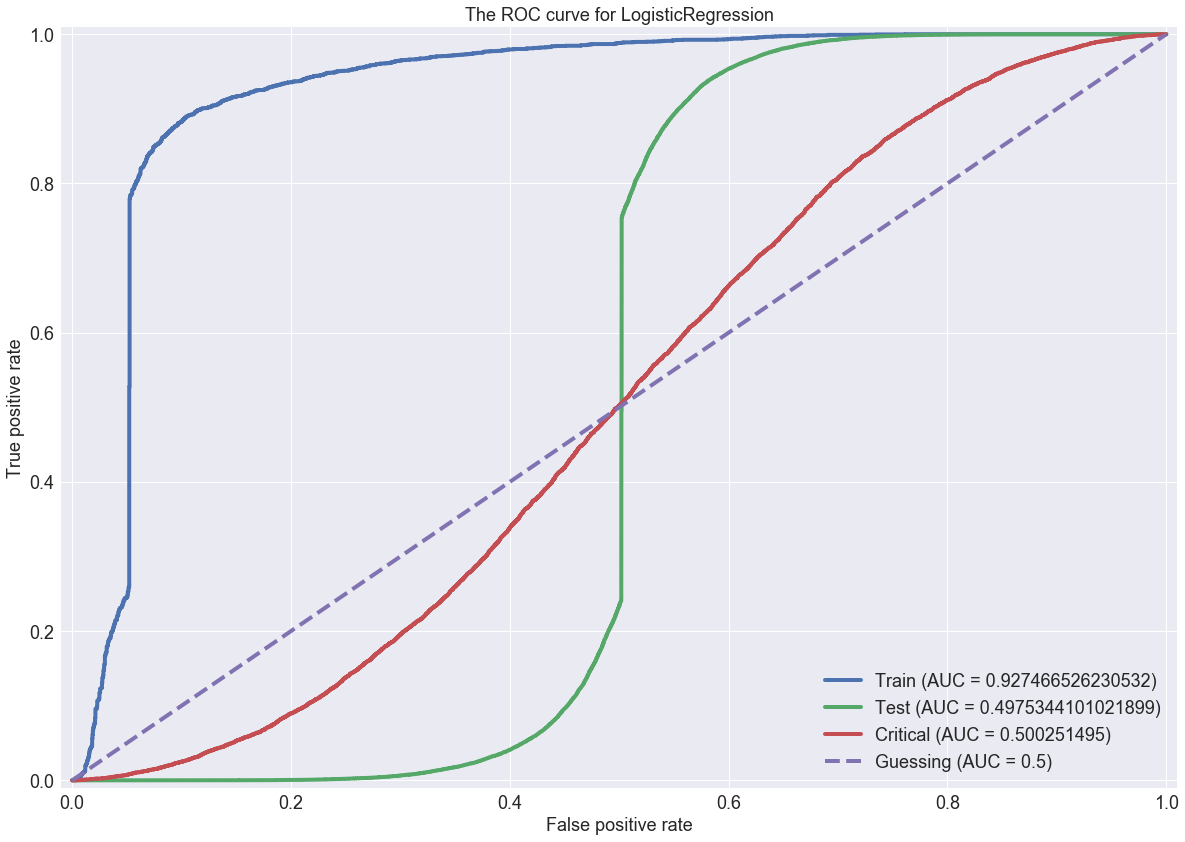

In [10]:
fig = plt.figure(figsize=(20, 14))

for (_X, _y), label in zip(
    [
        (X_train, y_train),
        (X_test, y_test),
        (data[critical], labels[critical])
    ],
    ["Train", "Test", "Critical"]
):
    proba = clf.predict_proba(_X)
    fpr, tpr, _ = skm.roc_curve(_y, proba[:, 1])
    roc_auc = skm.auc(fpr, tpr)

    print ("LogisticRegression AUC ({0}): {1}".format(label, roc_auc))

    plt.plot(fpr, tpr, label="{0} (AUC = {1})".format(label, roc_auc), linewidth=4.0)

plt.plot([0, 1], [0, 1], "--", label="Guessing (AUC = 0.5)", linewidth=4.0)

plt.title(r"The ROC curve for LogisticRegression", fontsize=18)
plt.xlabel(r"False positive rate", fontsize=18)
plt.ylabel(r"True positive rate", fontsize=18)
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc="best", fontsize=18)
plt.show()

We can see that this plot of the ROC looks very strange. This tells us that logistic regression is quite inept at predicting the Ising model transition and is therefore highly non-linear. The ROC curve for the training data looks quite good, but as the testing data is so far off we see that we are dealing with an overfit model.

A previous run with $50\%$ of the data used for training yielded a worse performance than using a smaller training set. This again gives confidence to the fact that logistic regression is not able to correctly fit the Ising model as it is not a linear model.

![](large_training_data.jpg)